<a href="https://colab.research.google.com/github/RifatXia/Projects/blob/master/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# loading CIFAR-10 dataset

from google.colab import drive
import pickle
import numpy as np
import os

# mount google drive to access files
drive.mount('/content/drive')

# function to load a single batch of cifar-10 data
def load_cifar10_batch(file):
    with open(file, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data']
        labels = batch[b'labels']
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, np.array(labels)

# load all training batches
data_dir = "/content/drive/My Drive/dataset/cifar-10/cifar-10-batches-py/"
train_images, train_labels = [], []

for i in range(1, 6):
    file_path = os.path.join(data_dir, f"data_batch_{i}")
    images, labels = load_cifar10_batch(file_path)
    train_images.append(images)
    train_labels.append(labels)

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

# load the test batch
test_images, test_labels = load_cifar10_batch(os.path.join(data_dir, "test_batch"))

# split training data into training and validation sets
val_split = 0.2  # 20% for validation
num_val_samples = int(len(train_images) * val_split)
val_images = train_images[:num_val_samples]
val_labels = train_labels[:num_val_samples]
train_images = train_images[num_val_samples:]
train_labels = train_labels[num_val_samples:]

print(f"train images shape: {train_images.shape}")
print(f"validation images shape: {val_images.shape}")
print(f"test images shape: {test_images.shape}")

# normalize pixel values to range [0, 1]
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

Mounted at /content/drive
train images shape: (40000, 32, 32, 3)
validation images shape: (10000, 32, 32, 3)
test images shape: (10000, 32, 32, 3)


In [2]:
# basic cnn model for cifar-10

import tensorflow as tf
from tensorflow.keras import layers, models

# build the cnn model
cnn_model_cifar10 = models.Sequential()

# add an input layer to avoid warnings
cnn_model_cifar10.add(layers.Input(shape=(32, 32, 3)))

# first convolution block
cnn_model_cifar10.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
cnn_model_cifar10.add(layers.MaxPooling2D((2, 2)))
cnn_model_cifar10.add(layers.BatchNormalization())

# second convolution block
cnn_model_cifar10.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model_cifar10.add(layers.MaxPooling2D((2, 2)))
cnn_model_cifar10.add(layers.BatchNormalization())

# third convolution block
cnn_model_cifar10.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model_cifar10.add(layers.MaxPooling2D((2, 2)))
cnn_model_cifar10.add(layers.BatchNormalization())

# flatten the output and pass through dense layers
cnn_model_cifar10.add(layers.Flatten())
cnn_model_cifar10.add(layers.Dense(128, activation='relu'))
cnn_model_cifar10.add(layers.Dense(10, activation='softmax'))  # 10 classes in cifar-10

# compile the model
cnn_model_cifar10.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

# train the model
history_cifar10 = cnn_model_cifar10.fit(train_images, train_labels, epochs=10,
                    validation_data=(val_images, val_labels))

# evaluate the model on the validation set
val_loss, val_acc = cnn_model_cifar10.evaluate(val_images, val_labels)
print(f"validation accuracy: {val_acc}")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4747 - loss: 1.5005 - val_accuracy: 0.6261 - val_loss: 1.0617
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.6969 - loss: 0.8703 - val_accuracy: 0.6302 - val_loss: 1.0528
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7602 - loss: 0.6729 - val_accuracy: 0.6976 - val_loss: 0.9036
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8216 - loss: 0.5128 - val_accuracy: 0.6815 - val_loss: 1.0656
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8663 - loss: 0.3835 - val_accuracy: 0.7132 - val_loss: 0.9392
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9067 - loss: 0.2747 - val_accuracy: 0.7300 - val_loss: 0.8954
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9295 - loss: 0.2064 - val_accuracy: 0.7324 - val_loss: 1.0435
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9454 - loss: 0.1

In [3]:
# replacing the convolution block with inception block for cifar-10

import tensorflow as tf
from tensorflow.keras import layers, models

# define an inception block
def inception_block(x, filters):
    # 1x1 convolution
    conv1x1 = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv3x3 = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)

    # 5x5 convolution
    conv5x5 = layers.Conv2D(filters, (5, 5), padding='same', activation='relu')(x)

    # max pooling followed by 1x1 convolution
    max_pool = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    max_pool_conv = layers.Conv2D(filters, (1, 1), padding='same', activation='relu')(max_pool)

    # concatenate all the outputs
    output = layers.Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, max_pool_conv])
    return output

# build the model using the functional api
inputs = layers.Input(shape=(32, 32, 3))

# first inception block
x = inception_block(inputs, 32)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

# second inception block
x = inception_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

# third inception block
x = inception_block(x, 128)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.BatchNormalization()(x)

# flatten and pass through dense layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)  # 10 classes for cifar-10

# create the model
cnn_model_inception_cifar10 = models.Model(inputs=inputs, outputs=outputs)

# compile the model
cnn_model_inception_cifar10.compile(optimizer='adam',
                                     loss='sparse_categorical_crossentropy',
                                     metrics=['accuracy'])

# train the model
history_inception_cifar10 = cnn_model_inception_cifar10.fit(train_images, train_labels, epochs=10,
                                                             validation_data=(val_images, val_labels))

# evaluate the model on the validation set
val_loss, val_acc = cnn_model_inception_cifar10.evaluate(val_images, val_labels)
print(f"validation accuracy: {val_acc:.4f}")


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.4671 - loss: 1.6288 - val_accuracy: 0.6479 - val_loss: 0.9993
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.6937 - loss: 0.8726 - val_accuracy: 0.7003 - val_loss: 0.8786
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7679 - loss: 0.6626 - val_accuracy: 0.6940 - val_loss: 0.8837
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.8277 - loss: 0.4935 - val_accuracy: 0.7537 - val_loss: 0.7844
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.8778 - loss: 0.3502 - val_accuracy: 0.7287 - val_loss: 0.9244
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9201 - loss: 0.2331 - val_accuracy: 0.7149 - val_loss: 1.0434
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9429 - loss: 0.1644 - val_accuracy: 0.7067 - val_loss: 1.1765
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9529 -

In [4]:
# replacing the inception block using residual block for cifar-10

import tensorflow as tf
from tensorflow.keras import layers, models

# define a residual block
def residual_block(x, filters):
    shortcut = x  # save input for the skip connection

    # first convolution layer
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # second convolution layer
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # if the number of channels of shortcut and x are different, apply a 1x1 convolution to shortcut
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    # skip connection: add input (shortcut) to output
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

# build the model using the functional api
inputs = layers.Input(shape=(32, 32, 3))

# first residual block
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = residual_block(x, 32)
x = layers.MaxPooling2D((2, 2))(x)

# second residual block
x = residual_block(x, 64)
x = layers.MaxPooling2D((2, 2))(x)

# third residual block
x = residual_block(x, 128)
x = layers.MaxPooling2D((2, 2))(x)

# flatten and pass through dense layers
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)  # 10 classes for cifar-10

# create the model
cnn_model_residual_cifar10 = models.Model(inputs=inputs, outputs=outputs)

# compile the model
cnn_model_residual_cifar10.compile(optimizer='adam',
                                    loss='sparse_categorical_crossentropy',
                                    metrics=['accuracy'])

# train the model
history_residual_cifar10 = cnn_model_residual_cifar10.fit(train_images, train_labels, epochs=10,
                                                          validation_data=(val_images, val_labels))

# evaluate the model on the validation set
val_loss, val_acc = cnn_model_residual_cifar10.evaluate(val_images, val_labels)
print(f"validation accuracy: {val_acc:.4f}")

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.4456 - loss: 1.5495 - val_accuracy: 0.6837 - val_loss: 0.8966
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7192 - loss: 0.8007 - val_accuracy: 0.7103 - val_loss: 0.8349
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7880 - loss: 0.6135 - val_accuracy: 0.7595 - val_loss: 0.7086
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8355 - loss: 0.4730 - val_accuracy: 0.7312 - val_loss: 0.8198
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8665 - loss: 0.3779 - val_accuracy: 0.7563 - val_loss: 0.7530
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8999 - loss: 0.2853 - val_accuracy: 0.7718 - val_loss: 0.7076
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9278 - loss: 0.2109 - val_accuracy: 0.7897 - val_loss: 0.6935
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9464 - loss: 0.160

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7166 - loss: 1.3426
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7456 - loss: 1.2345
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7826 - loss: 0.8886
Test Accuracy - CNN Model: 0.7186
Test Accuracy - Inception Model: 0.7437
Test Accuracy - Residual Model: 0.7757


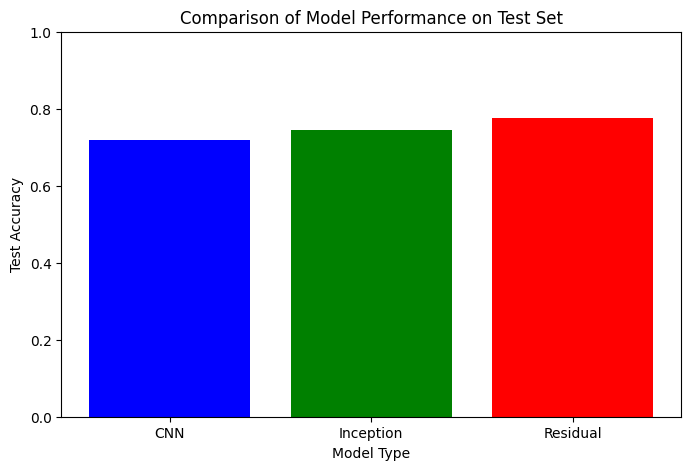

In [5]:
import matplotlib.pyplot as plt

# evaluate all models on the test set
test_loss_cnn, test_acc_cnn = cnn_model_cifar10.evaluate(test_images, test_labels)
test_loss_inception, test_acc_inception = cnn_model_inception_cifar10.evaluate(test_images, test_labels)
test_loss_residual, test_acc_residual = cnn_model_residual_cifar10.evaluate(test_images, test_labels)

# print test accuracy for each model
print(f"Test Accuracy - CNN Model: {test_acc_cnn:.4f}")
print(f"Test Accuracy - Inception Model: {test_acc_inception:.4f}")
print(f"Test Accuracy - Residual Model: {test_acc_residual:.4f}")

# plot comparison graph
models = ["CNN", "Inception", "Residual"]
accuracy = [test_acc_cnn, test_acc_inception, test_acc_residual]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracy, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Model Performance on Test Set")
plt.show()